In [14]:
import os
from google.cloud import bigquery
import google.auth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import date, timedelta
import seaborn as sns
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression  

%matplotlib inline 

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

SCOPE = ('https://www.googleapis.com/auth/bigquery',
         'https://www.googleapis.com/auth/bigtable.admin.table',
         'https://www.googleapis.com/auth/cloud-platform')

# This is cridential file for analytic-dev
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/ngovinh/Desktop/fna-select-only.json"
#
credentials, _ = google.auth.default(scopes=SCOPE)
#
client = bigquery.Client(project="tiki-dwh", credentials=credentials)

In [15]:
# Perform a query
query = """
with pageview_data as (
select format_date("%Y%V", time) as time,
count(user_pseudo_id) as pageview
from `tiki-dwh.fna.pageview_data_source_all_platform_2019*`
where master_sku = '4961734502696'
group by 1),

cmv_data as (
select 
format_date("%Y%V", date_key) as time,
sum(value) as cmv,
sum (qty) as qty
from `tiki-dwh.dwh.fact_sales_order_nmv`
left join `tiki-dwh.dwh.dim_product_full` 
using(product_key)
where order_type = 1
and (pmaster_sku = '4961734502696' or psuper_sku = '4961734502696')
and date_key >= '2019-01-01'
group by 1
)

select b.*, pageview
from pageview_data a
left join cmv_data b 
using (time)
where cmv is not null
order by 1
"""

df = pd.read_gbq(query,
                 project_id='tiki-dwh',
                 dialect='standard')

print(df.head())

INFO:pandas_gbq.gbq:  Elapsed 6.2 s. Waiting...
INFO:pandas_gbq.gbq:  Elapsed 7.25 s. Waiting...
INFO:pandas_gbq.gbq:  Elapsed 8.32 s. Waiting...
INFO:pandas_gbq.gbq:  Elapsed 9.41 s. Waiting...
INFO:pandas_gbq.gbq:  Elapsed 10.5 s. Waiting...
INFO:pandas_gbq.gbq:  Elapsed 11.56 s. Waiting...
INFO:pandas_gbq.gbq:  Elapsed 12.67 s. Waiting...
INFO:pandas_gbq.gbq:  Elapsed 13.75 s. Waiting...
INFO:pandas_gbq.gbq:  Elapsed 14.84 s. Waiting...
INFO:pandas_gbq.gbq:  Elapsed 15.92 s. Waiting...
INFO:pandas_gbq.gbq:Total time taken 18.26 s.
Finished at 2019-08-16 20:53:02.


     time         cmv  qty  pageview
0  201901   4290000.0  1.0       463
1  201902  13070000.0  3.0       680
2  201903  17960000.0  4.0       737
3  201904  21850000.0  5.0       567
4  201905   8780000.0  2.0       488


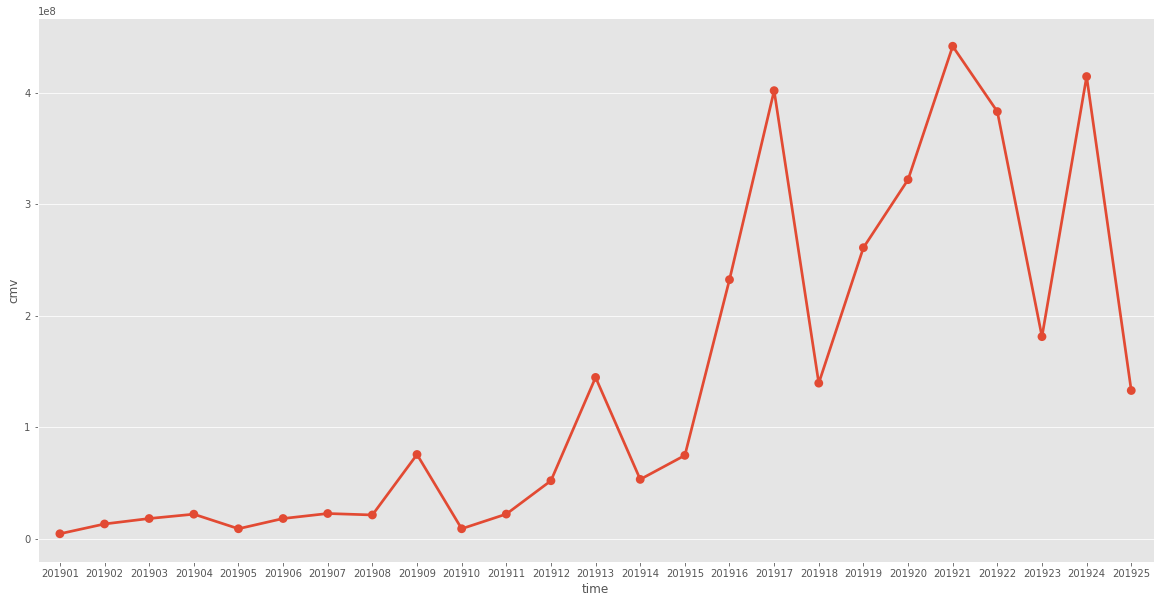

In [16]:
sns.pointplot("time", "cmv", data = df, linewidth=2.5)

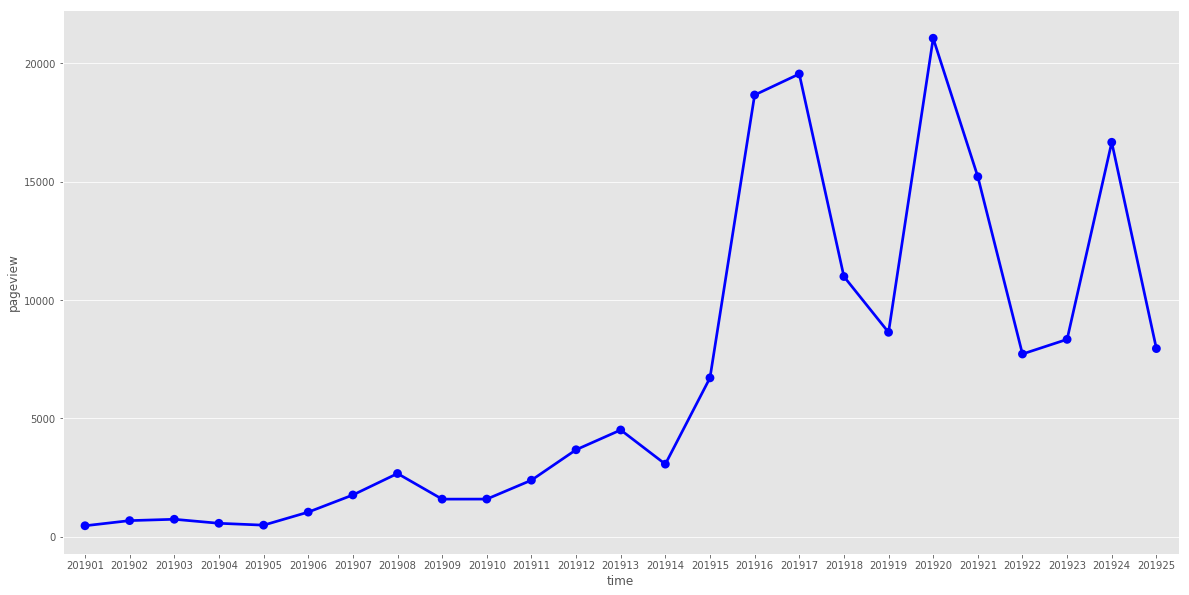

In [17]:
sns.pointplot("time", "pageview", data = df, linewidth=2.5, color = 'b')

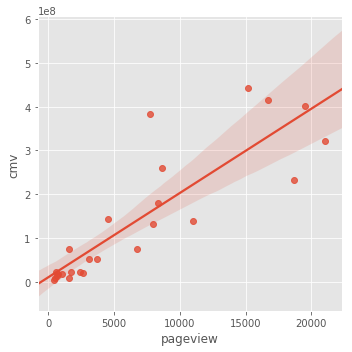

In [18]:
sns.lmplot("pageview","cmv", data = df)

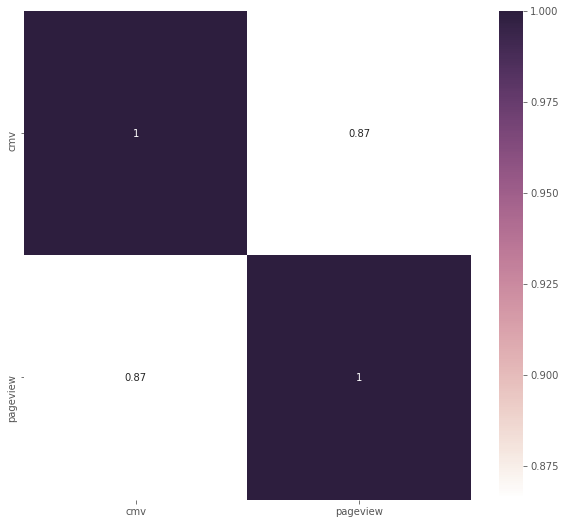

In [19]:
correlation = df[["cmv", "pageview"]].corr()
plt.figure(figsize = (10,9))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(correlation, cmap=cmap, annot=True)
plt.show()

In [20]:
X_train = df["pageview"].values.reshape(df["pageview"].count(),1)
y_train = df["cmv"].values.reshape(df["cmv"].count(),1)

regressor = LinearRegression().fit(X_train, y_train) 

print("score: "+ format(regressor.score(X_train, y_train)))

#a
print(regressor.coef_)

#b
print(regressor.intercept_)


score: 0.7492491744647924
[[19256.74901853]]
[10259920.8069033]


In [21]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     68.72
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           2.32e-08
Time:                        20:53:04   Log-Likelihood:                -488.10
No. Observations:                  25   AIC:                             980.2
Df Residuals:                      23   BIC:                             982.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.026e+07   2.17e+07      0.473      0.6